<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/navier_stokes_PINN_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This work is based on the methodology originally developed by [Raissi](https://github.com/maziarraissi/PINNs/blob/master/main/continuous_time_identification%20(Navier-Stokes)/NavierStokes.py), and the Tensorflow 2.0 modification by [Blechschmidt](https://github.com/janblechschmidt/PDEsByNNs) and [pierremtb ](https://github.com/pierremtb/PINNs-TF2.0).

A Tensorflow 2.0 implementation of the inference problem for the Navier Stokes equation is [here](https://github.com/yajuna/tensorflow_pde/blob/master/navier_stokes_PINN_Solver.ipynb). This notebook is a Tensorflow 2.0 implementation of the Navier Stokes identification problem. We run this notebook with the original data provided by the author to test our implementation for the inference problem. This code is modified from Blechschmidt, as well as [the heat identification code](https://github.com/yajuna/tensorflow_pde/blob/master/Heat_equation_with_tensorflow.ipynb)

``tf.experimental.numpy.experimental_enable_numpy_behavior()`` helps numpy commands such as ``.min()`` for tf eager tensors.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy.io

from time import time

from IPython.display import clear_output

tf.experimental.numpy.experimental_enable_numpy_behavior()

clear_output()

## Get data for Navier Stokes

Clone Raissi's original data for Navier Stokes equation.

In [ ]:
!git clone https://github.com/maziarraissi/PINNs

fatal: destination path 'PINNs' already exists and is not an empty directory.


## Define path for data and Python scripts from Raissi.

In [ ]:
import os
import sys

# "." for Colab/VSCode, and ".." for GitHub
repoPath = os.path.join(".", "PINNs")
# repoPath = os.path.join("..", "PINNs")
utilsPath = os.path.join(repoPath, "Utilities")
dataPath = os.path.join(repoPath, "main", "Data")
appDataPath = os.path.join(repoPath, "appendix", "Data")

## Define data type and set seed for reproducibility involving random choices.

In [ ]:
# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

## Define number of training points `N_train`. Read all data, `U_star` (with $u$ and $v$), `P_star`, `t_star`, and `X_star` (with $x$ and $y$).

Data reshaped and stored in `x,y,t,u,v,p`.

A random instance was chosen by `idx`, then a set of training points are chosen, labeled `*.train`. Testing data is picked from the original data at a time snap and not randomized (always taken at `snap`), labeled `*.star`.

Training data is listed in `X` and `data`, testing data is listed in `X_test` and `data_test`.

In [ ]:

N_train = 5000
N_r = 5000

path = os.path.join(dataPath, "cylinder_nektar_wake.mat")
data = scipy.io.loadmat(path)

# define training and testing data
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t.shape[0]

print('Size of x: N and size of t: T', N, T)

#Rearrange Data ----> like meshgrid
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

######################################################################
######################## Noiseless Data ##############################
######################################################################
# Training Data
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
print("x_train.shape@@@@", x_train.shape)
y_train = y[idx,:]
t_train = t[idx,:]

u_train = u[idx,:]
v_train = v[idx,:]
p_train = p[idx,:]

# Test Data
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

# make training and testing data
X_train = tf.concat([x_train,y_train,t_train], axis = 1)#tf.Variable()
data_train = tf.concat([u_train,v_train,p_train], axis = 1)

# # print boundary range ---------------> plot to understand range
# print(x.min())
# print(x.max())
# print(y.min())
# print(y.max())
# print(t.min())
# print(t.max())

# print(x_train.min())
# print(x_train.max())
# print(y_train.min())
# print(y_train.max())
# print(t_train.min())
# print(t_train.max())

# print(x_star.min())
# print(x_star.max())
# print(y_star.min())
# print(y_star.max())
# print(t_star.min())
# print(t_star.max())

lb = tf.constant([x_train.min(), y_train.min(), t_train.min()],dtype = DTYPE)
ub = tf.constant([x_train.max(), y_train.max(), t_train.max()],dtype = DTYPE)

X_test = tf.concat([x_star,y_star,t_star], axis = 1)
data_test = tf.concat([u_star,v_star,p_star], axis = 1)

# fll range data shape is 5000 by 200
# X_r = tf.concat([x, y, t], axis=1)

# print('size of X_r', X_r.shape)

print("X_star[:,0:1]", X_star[:,0:1])
print("XX", XX)

print("t", t)
print("TT", TT)

print(x_train)
print(y_train)
print(t_train)

Size of x: N and size of t: T 5000 200
x_train.shape@@@@ (5000, 1)
X_star[:,0:1] [[1.        ]
 [1.07070707]
 [1.14141414]
 ...
 [7.85858586]
 [7.92929293]
 [8.        ]]
XX [[1.         1.         1.         ... 1.         1.         1.        ]
 [1.07070707 1.07070707 1.07070707 ... 1.07070707 1.07070707 1.07070707]
 [1.14141414 1.14141414 1.14141414 ... 1.14141414 1.14141414 1.14141414]
 ...
 [7.85858586 7.85858586 7.85858586 ... 7.85858586 7.85858586 7.85858586]
 [7.92929293 7.92929293 7.92929293 ... 7.92929293 7.92929293 7.92929293]
 [8.         8.         8.         ... 8.         8.         8.        ]]
t [[ 0. ]
 [ 0.1]
 [ 0.2]
 ...
 [19.7]
 [19.8]
 [19.9]]
TT [[ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 ...
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]]
[[6.86868687]
 [3.68686869]
 [4.74747475]
 ...
 [3.05050505]
 [2.97979798]
 [1.98989899]]
[[-0.

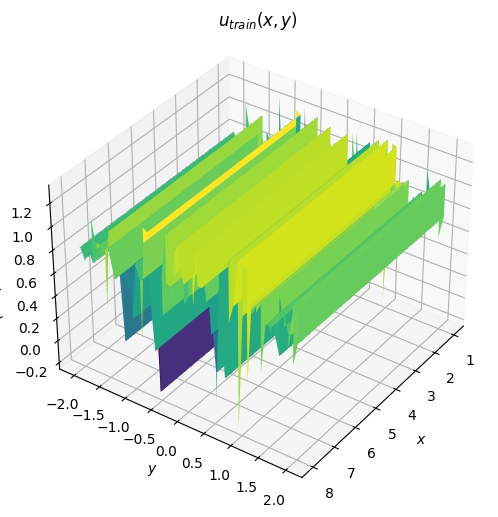

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Set up meshgrid for x and y
X, Y = np.meshgrid(X_star[:,0:1], X_star[:,1:2])
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

# Surface plot of initial condition u_0
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_train, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$u_{train}(x,y)$')
ax.set_title('$u_{train}(x,y)$');

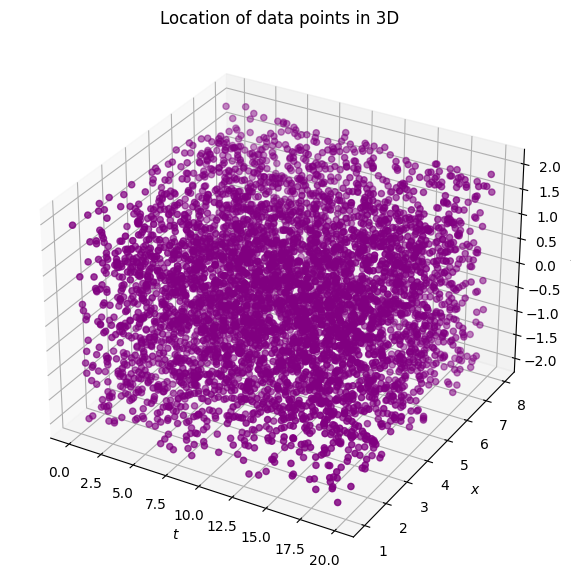

In [ ]:
# Import libraries
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection='3d')

# Creating plot
ax.scatter3D(t_train, x_train, y_train, color = "purple")
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$y$')
plt.title("Location of data points in 3D")

# show plot
plt.show()

## Print data to compare with OpenFoam generated data.

In [ ]:
# print information from Raissi training data
"""
Recall training data is defined from

U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

then rearranged to be
#Rearrange Data
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1
"""

# print('max and min of UU', UU.max(), UU.min())


"\nRecall training data is defined from\n\nU_star = data['U_star'] # N x 2 x T\nP_star = data['p_star'] # N x T\nt_star = data['t'] # T x 1\nX_star = data['X_star'] # N x 2\n\nthen rearranged to be\n#Rearrange Data\nXX = np.tile(X_star[:,0:1], (1,T)) # N x T\nYY = np.tile(X_star[:,1:2], (1,T)) # N x T\nTT = np.tile(t_star, (1,N)).T # N x T\n\nUU = U_star[:,0,:] # N x T\nVV = U_star[:,1,:] # N x T\nPP = P_star # N x T\n\nx = XX.flatten()[:,None] # NT x 1\ny = YY.flatten()[:,None] # NT x 1\nt = TT.flatten()[:,None] # NT x 1\n\nu = UU.flatten()[:,None] # NT x 1\nv = VV.flatten()[:,None] # NT x 1\np = PP.flatten()[:,None] # NT x 1\n"

In [ ]:
# ################### load data from google drive
# """
# To load data from Google Drive, download data from
# https://github.com/maziarraissi/PINNs/tree/master/main/Data
# and save it in a folder called "data" in your Google drive
# """
# from google.colab import drive
# drive.mount('/content/drive')
# data = scipy.io.loadmat('/content/drive/My Drive/data/cylinder_nektar_wake.mat')

## Define PINN_NeuralNet, define model architecture.

Input is three dimensional, consisting of $x$, $y$, and $t$. The output is one dimensional, consisting of concatenated $u$, $v$, and $p$.

The neural net has one scaling layer, several hidden dense layers, and one output layer.

In [ ]:
# Define model architecture

class PINN_NeuralNet(tf.keras.Model):
  """Basic architecture of the PINN model
  input dimension = 3, for x, y, t
  output dimension = 1 for u, v, and p concatenated
  """
# change input from lb, and ub to data from Raissi
  def __init__(self, lb, ub,
               output_dim = 1,
               num_hidden_layers = 8,
               num_neurons_per_layer = 20,
               activation = 'tanh',
               kernel_initializer = 'glorot_normal',
               **kwargs):
    super().__init__(**kwargs)

    self.num_hidden_layers = num_hidden_layers
    self.output_dim = output_dim

    self.lb = lb
    self.ub = ub

    # Define NN architecture
    self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0 * (x - self.lb)/(self.ub - self.lb) - 1.0)
    self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
    self.out = tf.keras.layers.Dense(output_dim)

  def call(self, X):
    """
    Forward-pass thru NN
    """
    Z = self.scale(X)
    for i in range(self.num_hidden_layers):
      Z = self.hidden[i](Z)
    return self.out(Z)

### Define PINNIdentificationNet, inherites from PINN_NeuralNet class.

This neural net includes the two parameters to identify, call them ``lambd_1`` and ``lambd_2``.

In [ ]:
# class PINNIdentificationNet(PINN_NeuralNet):
#     def __init__(self, *args, **kwargs):

#         # Call init of base class
#         super().__init__(*args,**kwargs)

#         # Initialize variable for lambda

#         self.lambd1 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
#         self.lambd1_list = []

#         self.lambd2 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
#         self.lambd2_list = []

## Define PINNSolver class.

Physics information is enforced at the training points `x/y/t_train`.

Initial and boundary conditions are included in these points, so only error at these points are considered.

In [ ]:
# X should be choosen training data of index idx, size N_train
class PINNSolver():
    def __init__(self, model, X):
        self.model = model

        # Store collocation points, separate t and x
        print("!!!! X_r !!!", X)



        self.x = X[:,0:1]
        self.y = X[:,1:2]
        self.t = X[:,2:3]
        print("print self.x, self.y, self.t from Class PINNSolver", self.x.size, self.y.size, self.t.size)
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

# differentiate to compute residual of PDE, physics information
    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.x)
            tape.watch(self.y)
            tape.watch(self.t)



            #############################Added by Yoshi##################

            print("")
            print("!!!CHECKING self.x", self.x)
            print("!!!CHECKING self.y", self.y)
            print("!!!CHECKING self.t", self.t) ###Problems with this....currently has shape (5000,0)
            print("")

            #############################Added by Yoshi##################
            # Check if any of the variables are empty
            if self.x.size == 0 or self.y.size == 0 or self.t.size == 0:
                raise ValueError("Input variables self.x, self.y, or self.t are empty.")
            ##########################################################




            # compute current psi and p; output of model stacked and labeled pp
            pp = self.model(tf.stack([self.x[:,0], self.y[:,0],self.t[:,0]], axis=1))
            print("size of pp from get_r in Class PINNSolver", pp.size)
            psi = pp[:,0:1]
            p = pp[:,1:2]
            print("size of psi and p from get_r in Class PINNSolver", psi.size, p.size)

            # Compute gradients
            u = tape.gradient(psi, self.y)
            print("max and min of u", u.max, u.min)
            v = -1 * tape.gradient(psi, self.x)
            print("type of v", type(v))
            u_x = tape.gradient(u, self.x)
            print("max and min of u_x", u_x.max, u_x.min)
            u_y = tape.gradient(u, self.y)
            print("max and min of u_y", u_y.max, u_y.min)
            v_x = tape.gradient(v, self.x)
            print("max and min v_x", v_x.max, v_x.min)
            v_y = tape.gradient(v, self.y)



        p_x = tape.gradient(p, self.x)
        p_y = tape.gradient(p, self.y)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        u_yy = tape.gradient(u_y, self.y)

        v_t = tape.gradient(v, self.t)
        v_xx = tape.gradient(v_x, self.x)
        v_yy = tape.gradient(v_y, self.y)

        del tape

        return self.fun_r(u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y)

# compute loss function- physics information + computational error
    def loss_fn(self, X, data):

        # Compute physics error from model and X_r; denote by phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # compute loss at input data- concatenated u, v, p minus computed u, v, p # original method only u and v


        self.x = X[:,0:1]
        self.y = X[:,1:2]
        self.t = X[:,2:3]
        print("")
        print("CHECKING self.x", self.x)
        print("CHECKING self.y", self.y)
        print("CHECING self.t", self.t)
        print("")


        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.x)
            tape.watch(self.y)
            pp_pred = self.model(tf.stack([self.x[:,0], self.y[:,0],self.t[:,0]], axis=1))
            print("print type of pp_pred", type(pp_pred))
            psi_pred = pp_pred[:,0:1]
            print("print type of psi_pred", type(psi_pred))
        # problem is somewhere here
        u_pred = tape.gradient(psi_pred, self.y)
        print("u_pred type", type(tape.gradient(psi_pred, self.y)))
        v_pred1 = tape.gradient(psi_pred, self.x)
        print("v_pred1", type(v_pred1), v_pred1)
        v_pred = -1 * v_pred1

        p_pred = pp_pred[:,1:2]
        data_pred = tf.concat([u_pred,v_pred,p_pred], axis = 1)
        loss += tf.reduce_mean(tf.square(data - data_pred))

        return loss


# from the model, get model trainable variables and keep for gradient descent
    def get_grad(self, X, data):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, data)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g

# compute residual from the neural net; physics information
    def fun_r(self, u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y):
        """Residual of the PDE"""
        # f = u_t + self.model.lambd1 * (u * u_x + v * u_y) + p_x - self.model.lambd2 * (u_xx + u_yy)
        # g = v_t + self.model.lambd1 * (u * v_x + v * v_y) + p_y - self.model.lambd2 * (v_xx + v_yy)
        f = u_t + (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        g = v_t + (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        return tf.concat([f, g], axis=1)

    def solve_with_TFoptimizer(self, optimizer, X, data, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, data)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def callback(self, xr=None):
        # lambd1 = self.model.lambd1.numpy()
        # self.model.lambd1_list.append(lambd1)

        # lambd2 = self.model.lambd2.numpy()
        # self.model.lambd2_list.append(lambd2)

        if self.iter % 100 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss))

        self.hist.append(self.current_loss)
        self.iter += 1


    def plot_solution(self, **kwargs):
        N = 411
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N)
        yspace = np.linspace(self.model.lb[2], self.model.ub[2], N)
        T, X, Y = np.meshgrid(tspace, xspace, yspace)
        Xgrid = np.vstack([T.flatten(),X.flatten(),Y.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N,N)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, Y, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        # # color = 'tab:blue'
        # ax2.tick_params(axis='y', labelcolor='tab:blue')
        # ax2.plot(range(len(self.hist)), self.model.lambd1_list,'-',color='tab:blue')
        # ax2.plot(range(len(self.hist)), self.model.lambd2_list,'-',color='tab:red')
        # ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color='tab:blue')
        return (ax1,ax2)

In [ ]:
# initialize model
model = PINN_NeuralNet(lb, ub)
model.build(input_shape=(None,3))

# initialize PINN solver
solver = PINNSolver(model, X_train)

!!!! X_r !!! tf.Tensor(
[[ 6.86868687 -0.28571429 15.3       ]
 [ 3.68686869  1.67346939 11.2       ]
 [ 4.74747475 -0.93877551 18.9       ]
 ...
 [ 3.05050505 -1.75510204  6.2       ]
 [ 2.97979798  1.10204082  7.7       ]
 [ 1.98989899  1.83673469  3.2       ]], shape=(5000, 3), dtype=float64)
print self.x, self.y, self.t from Class PINNSolver 5000 5000 5000


In [ ]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# start timer
t0 = time()

solver.solve_with_TFoptimizer(optim, X_train, data_train, N=6001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


!!!CHECKING self.x tf.Tensor(
[[6.86868687]
 [3.68686869]
 [4.74747475]
 ...
 [3.05050505]
 [2.97979798]
 [1.98989899]], shape=(5000, 1), dtype=float64)
!!!CHECKING self.y tf.Tensor(
[[-0.28571429]
 [ 1.67346939]
 [-0.93877551]
 ...
 [-1.75510204]
 [ 1.10204082]
 [ 1.83673469]], shape=(5000, 1), dtype=float64)
!!!CHECKING self.t tf.Tensor(
[[15.3]
 [11.2]
 [18.9]
 ...
 [ 6.2]
 [ 7.7]
 [ 3.2]], shape=(5000, 1), dtype=float64)



size of pp from get_r in Class PINNSolver 5000
size of psi and p from get_r in Class PINNSolver 5000 0
max and min of u <bound method amax of <tf.Tensor 'gradient_tape/strided_slice_1/StridedSliceGrad:0' shape=(5000, 1) dtype=float64>> <bound method amin of <tf.Tensor 'gradient_tape/strided_slice_1/StridedSliceGrad:0' shape=(5000, 1) dtype=float64>>
type of v <class 'tensorflow.python.framework.ops.SymbolicTensor'>
max and min of u_x <bound method amax of <tf.Tensor 'gradient_tape/strided_slice/StridedSliceGrad_2:0' shape=(5000, 1) dtype=float64>> <bound method amin of <tf.Tensor 'gradient_tape/strided_slice/StridedSliceGrad_2:0' shape=(5000, 1) dtype=float64>>
max and min of u_y <bound method amax of <tf.Tensor 'gradient_tape/strided_slice_1/StridedSliceGrad_3:0' shape=(5000, 1) dtype=float64>> <bound method amin of <tf.Tensor 'gradient_tape/strided_slice_1/StridedSliceGrad_3:0' shape=(5000, 1) dtype=float64>>
max and min v_x <bound method amax of <tf.Tensor 'gradient_tape/strided_sli

ValueError: in user code:

    File "<ipython-input-97-647b5a54f59a>", line 156, in train_step  *
        loss, grad_theta = self.get_grad(X, data)
    File "<ipython-input-97-647b5a54f59a>", line 135, in get_grad  *
        loss = self.loss_fn(X, data)
    File "<ipython-input-97-647b5a54f59a>", line 124, in loss_fn  *
        loss += tf.reduce_mean(tf.square(data - data_pred))

    ValueError: Dimensions must be equal, but are 3 and 2 for '{{node sub_2}} = Sub[T=DT_DOUBLE](sub_2/x, concat_1)' with input shapes: [5000,3], [5000,2].


In [ ]:
# solver.plot_solution();

In [ ]:
solver.plot_loss_history();

In [ ]:
solver.plot_loss_and_param();